## 1. Load Data & Libraries
We start by loading the fully cleaned dataset produced in `01_data_merge.ipynb`.


In [6]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/listening_history.csv")

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month'] = pd.to_datetime(df['month']).dt.to_period('M')

df.head()


/var/folders/fn/jg3vx9rd081c2p7hnwnbr_8w0000gn/T/ipykernel_14003/1539954752.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/listening_history.csv")


,timestamp,platform,ms_played,conn_country,ip_addr,track_name,artist_name,album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,month
0,2024-07-06 13:38:48+00:00,ios,4899,GB,92.40.218.69,Ogo,Seyi Vibez,Ogo,spotify:track:1zM2WWrMOt5Jt2jR39cBDp,NaN,...,NaN,NaN,clickrow,endplay,True,True,False,1.720271e+09,False,2024-07
1,2024-07-06 13:40:28+00:00,ios,99822,GB,92.40.218.69,C****l Bag,Rsko,Memory,spotify:track:1iglyuVDpikOnQHULBu1ss,NaN,...,NaN,NaN,clickrow,endplay,True,True,True,1.720273e+09,False,2024-07
2,2024-07-06 13:40:29+00:00,ios,1416,GB,92.40.218.69,La vie d'un... / Ma préférée,Dadju,HÉRITAGE,spotify:track:3IedXlFglIwo754rxOID4x,NaN,...,NaN,NaN,clickrow,endplay,True,True,True,1.720273e+09,False,2024-07
3,2024-07-06 13:41:35+00:00,ios,65131,GB,92.40.218.69,Inviolable,Popcaan,Inviolable - Single,spotify:track:6hix0bbbr6iSUfPlTGwlTv,NaN,...,NaN,NaN,clickrow,endplay,True,True,True,1.720273e+09,False,2024-07
4,2024-07-06 13:44:30+00:00,ios,177000,GB,92.40.218.69,Ogo,Seyi Vibez,Ogo,spotify:track:1zM2WWrMOt5Jt2jR39cBDp,NaN,...,NaN,NaN,clickrow,trackdone,True,False,True,1.720273e+09,False,2024-07


## 2. Exploratory Data Analysis
Before modeling, we explore listening patterns.


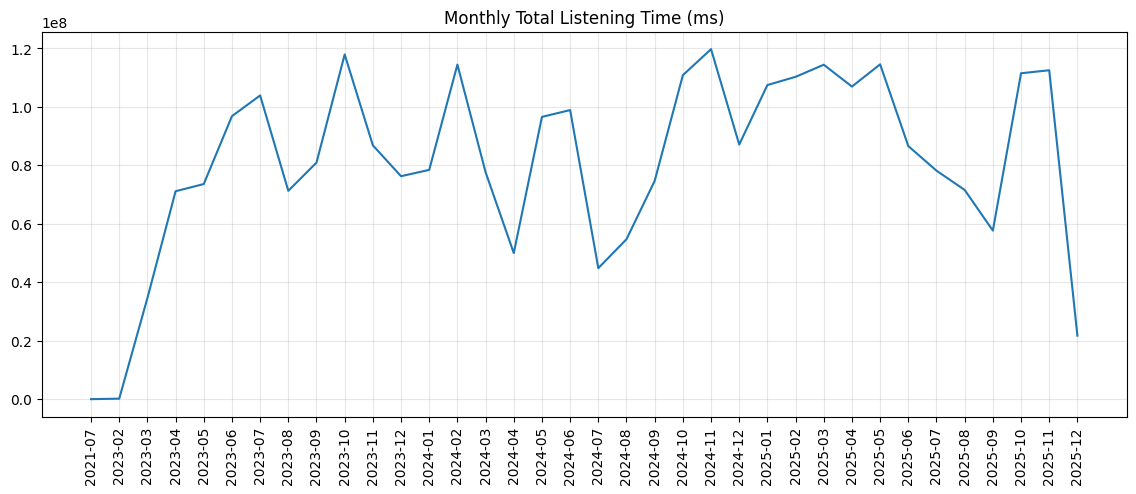

In [23]:
monthly_total = df.groupby('month')['ms_played'].sum()

plt.figure(figsize=(14,5))
plt.plot(monthly_total.index.astype(str), monthly_total.values)
plt.title("Monthly Total Listening Time (ms)")
plt.xticks(rotation=90)
plt.grid(alpha=0.3)
plt.show()


In [8]:
top_artists_overall = df.groupby("artist_name")["ms_played"].sum().sort_values(ascending=False).head(20)
top_artists_overall


artist_name
Burna Boy       221921487
Wizkid          137633987
Tiakola         112854757
Chris Brown      97384956
Fally Ipupa      81615777
Rsko             80407906
AMARIA BB        53326148
Seyi Vibez       49925564
Rema             49074952
Aya Nakamura     46542853
Ya Levis         45872379
J Hus            45539882
Azanti           34383079
Oxlade           31399355
Jacquees         29406401
Haile            26510171
Vianni           26487457
Tory Lanez       25754624
Eric IV          25667382
Merveille        25055390
Name: ms_played, dtype: int64

## 3. Monthly Aggregation for Artists

We create a monthly dataset for each artist — this is neeeded for forecasting.


In [9]:
monthly_artists = (
    df.groupby(['month', 'artist_name'])['ms_played']
    .sum()
    .reset_index()
)
monthly_artists.head()


,month,artist_name,ms_played
0,2021-07,Dave,51754
1,2023-02,Cruel Santino,110313
2,2023-02,DJ Kamol 2,49408
3,2023-02,Kid MARLEY,53290
4,2023-02,Poco Lee,8042


## 4. Identify Top Artists
We forecast only the top 20 artists (based on total listening time).


In [10]:
top_artists = (
    monthly_artists.groupby('artist_name')['ms_played']
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .index
)

top_artists


Index(['Burna Boy', 'Wizkid', 'Tiakola', 'Chris Brown', 'Fally Ipupa', 'Rsko',
       'AMARIA BB', 'Seyi Vibez', 'Rema', 'Aya Nakamura', 'Ya Levis', 'J Hus',
       'Azanti', 'Oxlade', 'Jacquees', 'Haile', 'Vianni', 'Tory Lanez',
       'Eric IV', 'Merveille'],
      dtype='object', name='artist_name')

### Visualize historical trend for top artist
Let's examine the listening trend for your #1 artist.


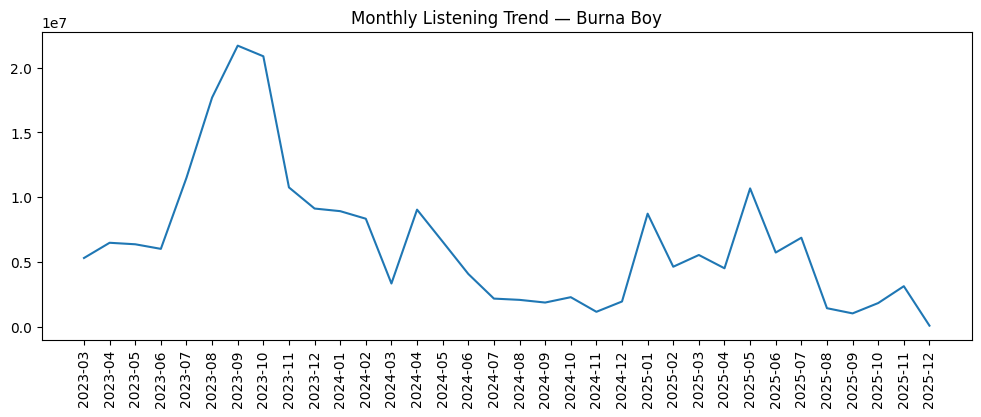

In [24]:
sample = top_artists[0]
sample_df = monthly_artists[monthly_artists['artist_name'] == sample]

plt.figure(figsize=(12,4))
plt.plot(sample_df['month'].astype(str), sample_df['ms_played'])
plt.title(f"Monthly Listening Trend — {sample}")
plt.xticks(rotation=90)
plt.show()


## 5. Forecast Example Artist with Prophet
We demonstrate the forecasting process using your #1 artist.


In [25]:
artist = top_artists[0]
artist_df = monthly_artists[monthly_artists['artist_name'] == artist].copy()

artist_df = artist_df.rename(columns={'month': 'ds', 'ms_played': 'y'})
artist_df['ds'] = artist_df['ds'].astype(str)

m = Prophet()
m.fit(artist_df)

future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)


19:32:28 - cmdstanpy - INFO - Chain [1] start processing
19:32:28 - cmdstanpy - INFO - Chain [1] done processing


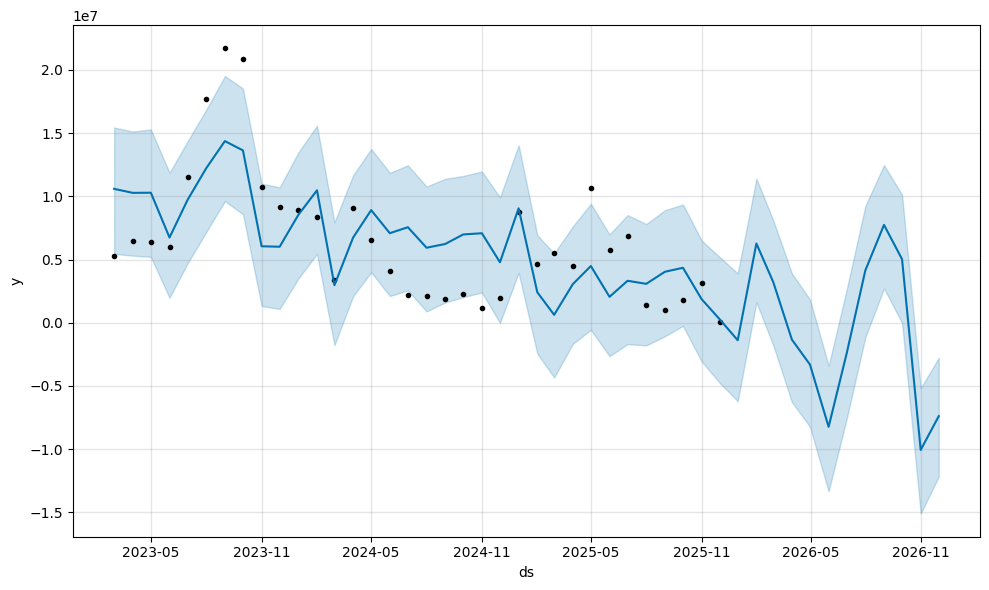

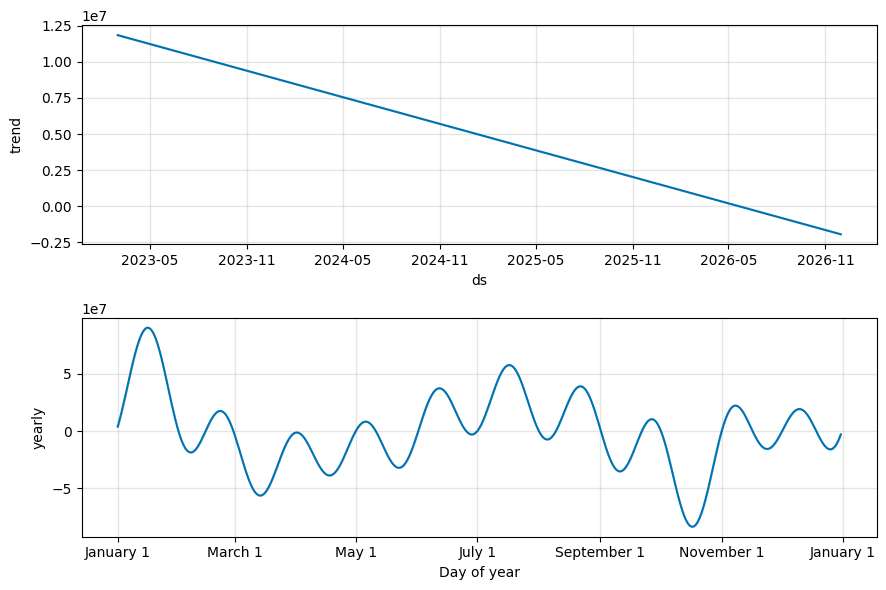

In [26]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


## 6. Forecast All Top Artists
We loop through all top artists and forecast their future listening time.


In [14]:
def forecast_artist(artist_name, df):
    artist_df = df[df['artist_name'] == artist_name].copy()
    artist_df = artist_df.rename(columns={'month':'ds','ms_played':'y'})
    artist_df['ds'] = artist_df['ds'].astype(str)

    m = Prophet()
    m.fit(artist_df)

    future = m.make_future_dataframe(periods=12, freq='M')
    forecast = m.predict(future)

    last = artist_df['ds'].max()
    future_pred = forecast[forecast['ds'] > last]
    future_pred['yhat'] = future_pred['yhat'].clip(lower=0)

    return future_pred['yhat'].sum()


In [15]:
artist_predictions = []

for artist in top_artists:
    total_future = forecast_artist(artist, monthly_artists)
    artist_predictions.append((artist, total_future))

artist_pred_df = pd.DataFrame(artist_predictions, columns=['artist_name','predicted_ms'])
artist_pred_df = artist_pred_df.sort_values('predicted_ms',ascending=False)
artist_pred_df


19:25:16 - cmdstanpy - INFO - Chain [1] start processing
19:25:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/fn/jg3vx9rd081c2p7hnwnbr_8w0000gn/T/ipykernel_14003/3649171394.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_pred['yhat'] = future_pred['yhat'].clip(lower=0)
19:25:16 - cmdstanpy - INFO - Chain [1] start processing
19:25:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/fn/jg3vx9rd081c2p7hnwnbr_8w0000gn/T/ipykernel_14003/3649171394.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

,artist_name,predicted_ms
11,J Hus,3.254701e+08
2,Tiakola,9.308982e+07
6,AMARIA BB,7.544842e+07
1,Wizkid,6.501267e+07
5,Rsko,6.483130e+07
9,Aya Nakamura,5.948600e+07
4,Fally Ipupa,5.220007e+07
10,Ya Levis,3.144131e+07
7,Seyi Vibez,2.840468e+07
0,Burna Boy,2.638891e+07


## 7. Predict Total Minutes for 2026


In [16]:
total_ms = artist_pred_df['predicted_ms'].sum()
total_minutes = total_ms / 60000
total_minutes


16415.10686326418

## 8. Forecast Top Songs
We use the same approach but for tracks.


In [17]:
monthly_tracks = (
    df.groupby(['month', 'track_name'])['ms_played']
    .sum()
    .reset_index()
)

top_tracks = (
    monthly_tracks.groupby("track_name")['ms_played']
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .index
)


In [18]:
song_predictions = []

for track in top_tracks:
    try:
        total_future = forecast_artist(track, monthly_tracks)   # reuse same function
        song_predictions.append((track, total_future))
    except:
        pass

song_pred_df = pd.DataFrame(song_predictions, columns=['track_name','predicted_ms'])
song_pred_df = song_pred_df.sort_values('predicted_ms', ascending=False)
song_pred_df.head(10)


,track_name,predicted_ms


## 9. Predict Top Albums for 2026
Based on historical patterns.


In [20]:
albums = (
    df.groupby('album_name')['ms_played']
    .sum()
    .sort_values(ascending=False)
)

albums


album_name
BDLM VOL.1               69796636
I Told Them...           51164460
Morayo                   45597714
Memory                   44154615
Outside                  37668862
                           ...   
Clock In/Green Speech           0
lemonade                        0
All That I Am                   0
Strength & Resilience           0
3AM in Oakland                  0
Name: ms_played, Length: 4408, dtype: int64

## 10. Export All Predictions to JSON
These files will be consumed by the React Wrapped UI.


In [ ]:
artist_pred_df.to_json("../predictions/artists.json", orient="records", indent=4)
song_pred_df.to_json("../predictions/songs.json", orient="records", indent=4)
albums.to_json("../predictions/albums.json", indent=4)

with open("../predictions/minutes.json","w") as f:
    f.write(json.dumps({"predicted_minutes": float(total_minutes)}, indent=4))


## 11. Summary & Insights

###  Predicted Top Artist of 2026
- **{{artist_pred_df.iloc[0,0]}}**

### Predicted Top Song
- **{{song_pred_df.iloc[0,0]}}**

### Total Listening Minutes in 2026
- **{{round(total_minutes)}} minutes**

### Top Album (historical)
- **{{albums.index[0]}}**

These predictions power the Spotify Wrapped UI built with React + Framer Motion.
This notebook documents the full modeling lifecycle for the project.
